# Evaluation: Lens Diffusion Model (UNet-DDPM)

In this notebook, we load a trained UNet-based DDPM checkpoint and evaluate the realism and variety of generated results using the Frechet Inception Distance(FID).


In [1]:
import torch
import torchvision
import numpy as np
import os
from pytorch_fid import fid_score
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
from models import UNet, UNetAtt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

### Load Model from Checkpoint

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = UNet().to(device)
model_att = UNetAtt().to(device)
model_att_ssim = UNetAtt().to(device)

# Load best checkpoint
checkpoint_path = "../../checkpoints/ddpm_90epc_2025-03-18_01-40-51.pth"
checkpoint_path_att = "../../checkpoints/ddpm_att_100epc_2025-03-25_15-16-57.pth"
checkpoint_path_att_ssim = "../../checkpoints/ddpm_90epc_2025-03-25_18-23-52.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
model_att.load_state_dict(torch.load(checkpoint_path_att, map_location=device))
model_att.eval()
model_att_ssim.load_state_dict(torch.load(checkpoint_path_att_ssim, map_location=device))
model_att_ssim.eval()
print(f"[INFO] Loaded checkpoint from {checkpoint_path}, {checkpoint_path_att}, {checkpoint_path_att_ssim}")

Using device: cuda
[INFO] Loaded checkpoint from ../../checkpoints/ddpm_90epc_2025-03-18_01-40-51.pth, ../../checkpoints/ddpm_att_100epc_2025-03-25_15-16-57.pth, ../../checkpoints/ddpm_90epc_2025-03-25_18-23-52.pth


### Generate Samples

In [3]:
timesteps = 1000
betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
alphas = 1.0 - betas
alpha_cumprod = torch.cumprod(alphas, dim=0)

def generate_samples(model, num_samples=16):
    samples = torch.randn((num_samples, 1, 150, 150)).to(device)
    with torch.no_grad():
        for i in reversed(range(timesteps)):
            t = torch.full((num_samples,), i, device=device).long()
            beta_t = betas[i]
            alpha_t = alphas[i]
            alpha_cumprod_t = alpha_cumprod[i]
            
            noise_pred = model(samples, t.float())

            if i > 0:
                noise = torch.randn_like(samples)
            else:
                noise = torch.zeros_like(samples)

            # Use correct reverse formula
            samples = (1 / torch.sqrt(alpha_t)) * (
                samples - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * noise_pred
            ) + torch.sqrt(beta_t) * noise

    return samples.cpu()

def add_noise(x, t, noise=None):
    """
    Adds noise to the image x at a specific timestep t using the forward diffusion process.
    """
    if noise is None:
        noise = torch.randn_like(x).to(device)
    sqrt_alpha_cumprod = torch.sqrt(alpha_cumprod[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - alpha_cumprod[t]).view(-1, 1, 1, 1)
    return sqrt_alpha_cumprod * x + sqrt_one_minus_alpha_cumprod * noise, noise


For model without self-attention:

In [ ]:
# Generate and save samples
generated_images = generate_samples(model, num_samples=100)
generated_dir = "../../generated_samples/wo_att"
os.makedirs(generated_dir, exist_ok=True)

for idx, img in enumerate(generated_images):
    img_np = img.detach().cpu().numpy()  # convert tensor to numpy
    np.save(os.path.join(generated_dir, f"img_{idx}.npy"), img_np)

In [11]:
def vis_three_images(generated_img, original_img, noised_img):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(generated_img.squeeze(), cmap="gray")
    axs[0].set_title(f"Generated Image(t=1000)\nShape: {generated_img.shape}")
    axs[0].axis("off")

    axs[1].imshow(original_img.squeeze(), cmap="gray")
    axs[1].set_title(f"Original Image\nShape: {original_img.shape}")
    axs[1].axis("off")

    axs[2].imshow(noised_img.squeeze(), cmap="gray")
    axs[2].set_title(f"Noised Image (t=1000)\nShape: {noised_img.shape}")
    axs[2].axis("off")

    plt.show()


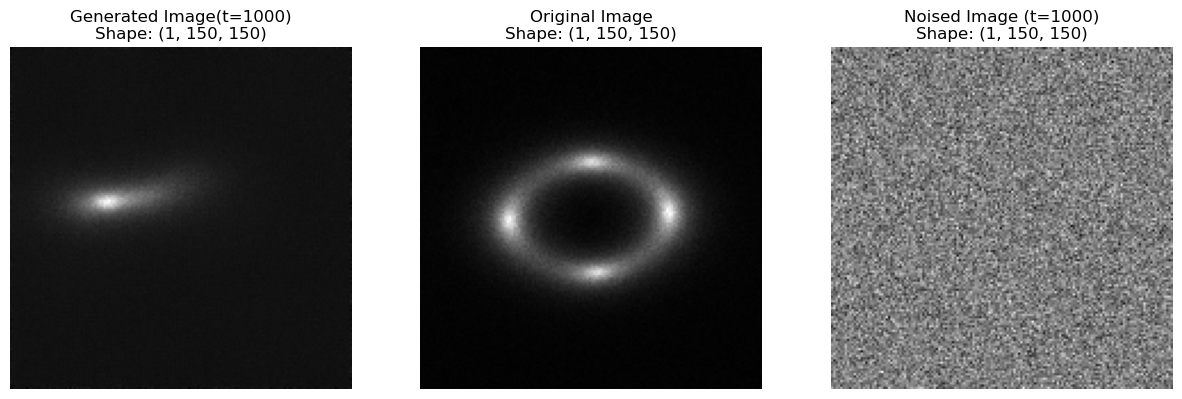

In [ ]:
# Load data
generated_img = np.load("../../generated_samples/wo_att/img_16.npy")
sample_image = np.load("../../Samples/sample19.npy")
sample_image_tensor = torch.from_numpy(sample_image).float().to(device)
noised_img, _ = add_noise(sample_image_tensor, 999)
noised_img = noised_img.detach().cpu().numpy().squeeze(0)

# Visualize all three
vis_three_images(generated_img, sample_image, noised_img)

For model with self-attention(MSE Loss):

In [13]:
# Generate and save samples
generated_images = generate_samples(model_att, num_samples=100)
generated_dir = "../../generated_samples/att"
os.makedirs(generated_dir, exist_ok=True)

for idx, img in enumerate(generated_images):
    img_np = img.detach().cpu().numpy()  # convert tensor to numpy
    np.save(os.path.join(generated_dir, f"img_{idx}.npy"), img_np)

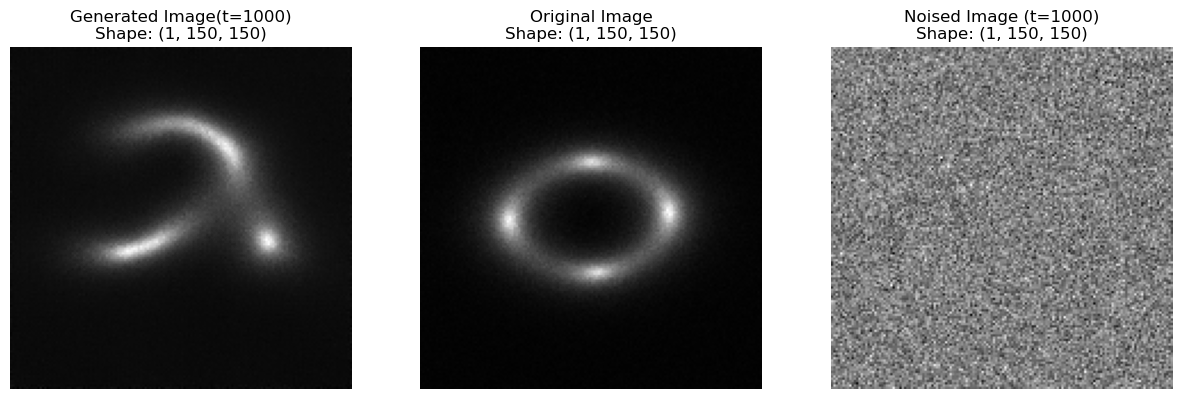

In [14]:
# Load data
generated_img = np.load("../../generated_samples/att/img_1.npy")
sample_image = np.load("../../Samples/sample19.npy")
sample_image_tensor = torch.from_numpy(sample_image).float().to(device)
noised_img, _ = add_noise(sample_image_tensor, 999)
noised_img = noised_img.detach().cpu().numpy().squeeze(0)

# Visualize all three
vis_three_images(generated_img, sample_image, noised_img)

For model with self-attention(MSE+SSIM):

In [31]:
# Generate and save samples
generated_images = generate_samples(model_att_ssim, num_samples=100)
generated_dir = "../../generated_samples/att_ssim"
os.makedirs(generated_dir, exist_ok=True)

for idx, img in enumerate(generated_images):
    img_np = img.detach().cpu().numpy()  # convert tensor to numpy
    np.save(os.path.join(generated_dir, f"img_{idx}.npy"), img_np)

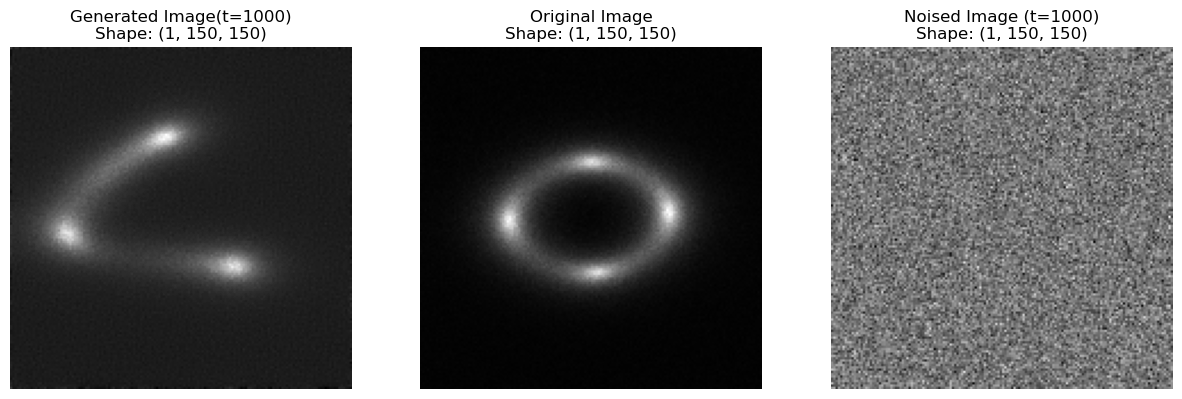

In [40]:
# Load data
generated_img = np.load("../../generated_samples/att_ssim/img_19.npy")
sample_image = np.load("../../Samples/sample19.npy")
sample_image_tensor = torch.from_numpy(sample_image).float().to(device)
noised_img, _ = add_noise(sample_image_tensor, 999)
noised_img = noised_img.detach().cpu().numpy().squeeze(0)

# Visualize all three
vis_three_images(generated_img, sample_image, noised_img)

### Compute FID

In [21]:
from torchvision.models import inception_v3
import torch.nn.functional as F

def load_npy_images(directory):
    imgs = []
    for fname in os.listdir(directory):
        if fname.endswith('.npy'):
            img = np.load(os.path.join(directory, fname)).squeeze(0)
            img = (img - img.min()) / (img.max() - img.min())
            img = np.stack([img, img, img], axis=0)
            imgs.append(img)
    return torch.tensor(np.stack(imgs), dtype=torch.float32)

def get_activations(images, model, batch_size=16):
    acts = []
    with torch.no_grad():
        for i in range(0, images.size(0), batch_size):
            batch = images[i:i+batch_size]
            pred = model(batch).flatten(start_dim=1)
            acts.append(pred.cpu())
    return torch.cat(acts, dim=0).numpy()


In [ ]:
# Randomly sample 100 images from Samples/
import random
import shutil

real_dir = "../../Samples"
sample_dir = "../../Samples_subset"
os.makedirs(sample_dir, exist_ok=True)

all_files = [f for f in os.listdir(real_dir) if f.endswith('.npy')]
sample_files = random.sample(all_files, 100)

for fname in sample_files:
    shutil.copy(os.path.join(real_dir, fname), os.path.join(sample_dir, fname))

Compute FID score for UNet with only CNNs.

In [25]:
# Load images
real_images = load_npy_images("../../Samples_subset").to(device)
fake_images = load_npy_images("../../generated_samples/wo_att").to(device)

# Resize images to 299x299 for inception_v3
real_images = F.interpolate(real_images, size=(299,299), mode='bilinear', align_corners=False)
fake_images = F.interpolate(fake_images, size=(299,299), mode='bilinear', align_corners=False)

# Get inception features
inception = inception_v3(pretrained=True, transform_input=False).to(device).eval()

real_acts = get_activations(real_images, inception)
fake_acts = get_activations(fake_images, inception)

# Compute FID
mu_real, sigma_real = real_acts.mean(axis=0), np.cov(real_acts, rowvar=False)
mu_fake, sigma_fake = fake_acts.mean(axis=0), np.cov(fake_acts, rowvar=False)

fid = fid_score.calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"FID Score for UNet with only CNNs: {fid}")


FID Score for UNet with only CNNs: 528.5094756008772


For UNet with self-attention(MSE Loss).

In [26]:
fake_images_att = load_npy_images("../../generated_samples/att").to(device)
fake_images_att = F.interpolate(fake_images_att, size=(299,299), mode='bilinear', align_corners=False)
fake_acts_att = get_activations(fake_images_att, inception)
mu_fake_att, sigma_fake_att = fake_acts_att.mean(axis=0), np.cov(fake_acts_att, rowvar=False)

fid_att = fid_score.calculate_frechet_distance(mu_real, sigma_real, mu_fake_att, sigma_fake_att)
print(f"FID Score for UNet with Self-attention(MSELoss): {fid_att}")

FID Score for UNet with Self-attention(MSELoss): 359.4629730791344


For UNet with self-attention(MSE+SSIM).

In [42]:
fake_images_att_ssim = load_npy_images("../../generated_samples/att_ssim").to(device)
fake_images_att_ssim = F.interpolate(fake_images_att_ssim, size=(299,299), mode='bilinear', align_corners=False)
fake_acts_att_ssim = get_activations(fake_images_att_ssim, inception)
mu_fake_att_ssim, sigma_fake_att_ssim = fake_acts_att_ssim.mean(axis=0), np.cov(fake_acts_att_ssim, rowvar=False)

fid_att_ssim = fid_score.calculate_frechet_distance(mu_real, sigma_real, mu_fake_att_ssim, sigma_fake_att_ssim)
print(f"FID Score for UNet with Self-attention(MSE+SSIM): {fid_att_ssim}")

FID Score for UNet with Self-attention(MSE+SSIM): 381.7554384318595
